In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import pickle
import cv2
from tensorflow.python.client import device_lib
import math
import pandas as pd
device_lib.list_local_devices()
import shutil
import pathlib
import random
import sys
import colorsys
import copy
from sklearn.preprocessing import StandardScaler

In [2]:
#######creat training data
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Acceleration.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
Acceleration =[]  
for i in range(len(data)):
    Acceleration.append(data[i].strip('\n').split("\t"))
Time_data =  np.array(Acceleration,dtype=np.float32)[:,0:1]
print(Time_data.shape)
Acceleration = np.array(Acceleration,dtype=np.float32)[:,1:]
print(Acceleration.shape)
####人为缩放
A_w = np.array([1e3,1e3,1,1,1,10,1,1,1,1])
Acceleration =  Acceleration * np.array(A_w) 
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Displacement.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
Displacement =[]    
for i in range(len(data)):
    Displacement.append(data[i].strip('\n').split("\t"))
Displacement = np.array(Displacement,dtype=np.float32)[:,1:] 
print(Displacement.shape)
####人为缩放
D_w = np.array([1,1e5,10,1e4,10,1e5,1e4,1e4,1e4,1e5])
Displacement =  Displacement * np.array(D_w) 
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Velocity.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
Velocity =[]    
for i in range(len(data)):
    Velocity.append(data[i].strip('\n').split("\t"))
Velocity = np.array(Velocity,dtype=np.float32)[:,1:] 
print(Velocity.shape)
####人为缩放
V_w = np.array([1e3,1e4,1e3,1e2,1e3,1e3,1e2,1e2,1e2,1e2])
Velocity =Velocity* np.array(V_w) 
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Irregularity.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
Irregularity =[]    
for i in range(len(data)):
    Irregularity.append(data[i].strip('\n').split("\t"))
Irregularity = np.array(Irregularity,dtype=np.float32)[:,1:]
print(Irregularity.shape)
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Mass_vehicle.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
M_matrix =[]    
for i in range(len(data)):
    M_matrix.append(data[i].strip('\n').split("\t"))
M_matrix= np.array(M_matrix,dtype=np.float32) 
print(M_matrix.shape)
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Damping_vehicle.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
C_matrix =[]    
for i in range(len(data)):
    C_matrix.append(data[i].strip('\n').split("\t"))
C_matrix= np.array(C_matrix,dtype=np.float32) 
print(C_matrix.shape)
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Stiffness_vehicle.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
K_matrix =[]    
for i in range(len(data)):
    K_matrix.append(data[i].strip('\n').split("\t"))
K_matrix= np.array(K_matrix,dtype=np.float32) 
print(K_matrix.shape)
with open(r'E:\NTU-work\Standard\VICT_10DOFs_230904\Force_vehicle.txt', 'r', encoding='utf-8') as f:
     data = f.readlines()
F =[]  
for i in range(len(data)):
    tem = data[i].split("  ")[0].split("\t")[:-1]
    print(np.array(tem).shape)
    F.append(tem)
F=F[:-1]
F= np.array(F,dtype=np.float32).T
print(F.shape)

###划分100长度数据
train_Acceleration = Acceleration
train_Velocity = Velocity
train_Displacement = Displacement
train_Irregularity = Irregularity
train_Time_data = Time_data
train_F = F
interval = 100
train_A_data=[]
train_V_data=[]
train_U_data=[]
train_Irr_data=[]
train_t_data=[]
train_F_data=[]
for i in range(int((len(train_Acceleration)-100)/interval)):
    train_A_data.append(train_Acceleration[i*interval:i*interval+100,:])
    train_V_data.append(train_Velocity[i*interval:i*interval+100,:])
    train_U_data.append(train_Displacement[i*interval:i*interval+100,:])
    train_Irr_data.append(train_Irregularity[i*interval:i*interval+100,:])
    train_t_data.append(train_Time_data[i*interval:i*interval+100,:])
    train_F_data.append(train_F[i*interval:i*interval+100,:])
train_A_data=np.array(train_A_data)
train_V_data=np.array(train_V_data)
train_U_data=np.array(train_U_data)
train_Irr_data=np.array(train_Irr_data)
train_t_data=np.array(train_t_data)
train_F_data=np.array(train_F_data)
print(train_A_data.shape)
print(train_V_data.shape)
print(train_U_data.shape)
print(train_Irr_data.shape)
print(train_t_data.shape)
print(train_F_data.shape)

#error =  Acceleration[555:565]@M_matrix + Velocity[555:565]@C_matrix + Displacement[555:565]@K_matrix-F[555:565]
Ishape = train_Irr_data.shape
Ashape = train_A_data.shape
Vshape = train_V_data.shape
Ushape = train_U_data.shape
Fshape = train_F_data.shape
scaler_I = StandardScaler()
scaled_train_Irr_data = scaler_I.fit_transform(train_Irr_data.reshape(-1,1)).reshape(Ishape)
scaler_A = StandardScaler()
scaler_V = StandardScaler()
scaler_U = StandardScaler()
scaled_train_A_data = scaler_A.fit_transform(train_A_data.reshape(-1,1)).reshape(Ashape)
scaled_train_V_data = scaler_V.fit_transform(train_V_data.reshape(-1,1)).reshape(Vshape)
scaled_train_U_data = scaler_U.fit_transform(train_U_data.reshape(-1,1)).reshape(Ushape)
scaler_F = StandardScaler()
scaled_train_F_data = scaler_F.fit_transform(train_F_data.reshape(-1,1)).reshape(Fshape)

train_Real_Y_data = np.array([scaled_train_A_data,scaled_train_V_data,scaled_train_U_data])
print(train_Real_Y_data.shape)
mean_A,std_A = scaler_A.mean_[0], scaler_A.scale_[0]
mean_V,std_V = scaler_V.mean_[0], scaler_V.scale_[0]
mean_U,std_U = scaler_U.mean_[0], scaler_U.scale_[0]
mean_F,std_F = scaler_F.mean_[0], scaler_F.scale_[0]

(85000, 1)
(85000, 10)
(85000, 10)
(85000, 10)
(85000, 4)
(10, 10)
(10, 10)
(10, 10)
(85000,)
(85000,)
(85000,)
(85000,)
(85000,)
(85000,)
(85000,)
(85000,)
(85000,)
(85000,)
(0,)
(85000, 10)
(849, 100, 10)
(849, 100, 10)
(849, 100, 10)
(849, 100, 4)
(849, 100, 1)
(849, 100, 10)
(3, 849, 100, 10)


In [3]:
def scaled_dot_product_attention(Q, K, V,
                                 dropout_rate=0.1,
                                 training=True,
                                 scope="scaled_dot_product_attention"):
    '''
    Q: Packed queries. 3d tensor. [N, T_q, d_k].
    K: Packed keys. 3d tensor. [N, T_k, d_k].
    V: Packed values. 3d tensor. [N, T_k, d_v].
    key_masks: A 2d tensor with shape of [N, key_seqlen]
    causality: If True, applies masking for future blinding
    dropout_rate: A floating point number of [0, 1].
    training: boolean for controlling droput
    scope: Optional scope for `variable_scope`.
    '''
    d_k = Q.get_shape().as_list()[-1]

    # dot product
    outputs = tf.matmul(Q, tf.transpose(K, [0, 2, 1]))  # (N, T_q, T_k)

    # scale
    outputs /= d_k ** 0.5

    # softmax
    outputs = tf.nn.softmax(outputs)

    # dropout
    outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)

    # weighted sum (context vectors)
    outputs = tf.matmul(outputs, V)  # (N, T_q, d_v)

    return outputs
    
def multihead_attention(queries, keys, values,
                        num_heads=8, 
                        dropout_rate=0.1,
                        training=True,
                        scope="multihead_attention"):
    '''
    queries: A 3d tensor with shape of [N, T_q, d_model].
    keys: A 3d tensor with shape of [N, T_k, d_model].
    values: A 3d tensor with shape of [N, T_k, d_model].
    key_masks: A 2d tensor with shape of [N, key_seqlen]
    num_heads: An int. Number of heads.
    dropout_rate: A floating point number.
    training: Boolean. Controller of mechanism for dropout.
    causality: Boolean. If true, units that reference the future are masked.
    scope: Optional scope for `variable_scope`.
        
    Returns
      A 3d tensor with shape of (N, T_q, C)  
    '''
    d_model = queries.get_shape().as_list()[-1]
    # Linear projections
    Q = tf.keras.layers.Dense(d_model)(queries) # (N, T_q, d_model) 
    K = tf.keras.layers.Dense(d_model)(keys) # (N, T_k, d_model)
    V = tf.keras.layers.Dense(d_model)(values)# (N, T_v, d_model)
    
    # Split and concat
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0) # (h*N, T_q, d_model/h)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0) # (h*N, T_k, d_model/h)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0) # (h*N, T_v, d_model/h)

    # Attention
    outputs =  scaled_dot_product_attention(Q_, K_, V_, dropout_rate, training)

    # Restore shape
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2 ) # (N, T_q, d_model)

    # Residual connection
    outputs = tf.keras.layers.add([queries,outputs])

    # Normalize
    outputs = tf.keras.layers.LayerNormalization()(outputs)
 
    return outputs

def ff(inputs, num_units, scope="positionwise_feedforward"):
    '''
    inputs: A 3d tensor with shape of [N, T, C].
    num_units: A list of two integers.
    scope: Optional scope for `variable_scope`.
    Returns:
      A 3d tensor with the same shape and dtype as inputs
    '''
    # Inner layer
    outputs = tf.keras.layers.Dense(num_units[0], activation=tf.nn.relu)(inputs) 

    # Outer layer
    outputs = tf.keras.layers.Dense(num_units[1])(outputs)

    # Residual connection
    outputs = tf.keras.layers.concatenate([outputs, inputs],axis=-1)

    # Normalize
    outputs = tf.keras.layers.LayerNormalization()(outputs)
    
    return outputs

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000 ** (2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000 ** (2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'dtype': self.dtype,
        })
        return config

In [5]:
def SeATransConv_PINN():
    #####part1
    Irregularity_input = tf.keras.layers.Input(shape=(100,4)) #后4列为轨道不平顺值
    Irregularity_F = tf.keras.layers.Input(shape=(100,10)) #F值
    encoder_in = tf.keras.layers.Dense(64)(Irregularity_input) #(None,100,64)
    decoder_in = tf.keras.layers.Dense(64)(Irregularity_F) #(None,100,64)
   
    positional_encoding = PositionalEncoding(max_steps=100, max_dims=64)
    
    encoder_in = positional_encoding(encoder_in)
    decoder_in = positional_encoding(decoder_in)
    
    layer1 = multihead_attention(encoder_in,encoder_in,decoder_in)
    layer2 = ff(layer1, [128,128])
    
    layer3 = multihead_attention(encoder_in, decoder_in, decoder_in)
    layer4 = multihead_attention(layer3, layer2, decoder_in)
    
    layer5 = ff(layer4, [128,128])
    layer6 = tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu)(layer5)
    LayerNorm1 = tf.keras.layers.LayerNormalization(axis=-1)(layer6)
    Dense3 =  tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(LayerNorm1)
    layer_A = tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)(Dense3)
    LayerNormA = tf.keras.layers.LayerNormalization(axis=-1)(layer_A)
    layer_A = tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)(LayerNormA)
    A = tf.keras.layers.Dense(10)(layer_A)
    layer_V = tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)(Dense3)
    LayerNormV = tf.keras.layers.LayerNormalization(axis=-1)(layer_V)
    layer_V = tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)(LayerNormV)
    V = tf.keras.layers.Dense(10)(layer_V)
    layer_U = tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)(Dense3)
    LayerNormU = tf.keras.layers.LayerNormalization(axis=-1)(layer_U)
    layer_U = tf.keras.layers.Dense(64,activation=tf.nn.leaky_relu)(LayerNormU)
    U = tf.keras.layers.Dense(10)(layer_U)
    #####part2
    Conv_input = tf.keras.layers.concatenate([encoder_in[...,tf.newaxis],decoder_in[...,tf.newaxis]],axis=-1)
    Conv_1 = tf.keras.layers.Conv2D(10,kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_input)
    Conv_1T = tf.transpose(Conv_1,[0,1,3,2])
    Conv_2 = tf.keras.layers.Conv2D(64,kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_1T)
    Conv_3 = tf.keras.layers.Conv2D(64,kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_2)
    Conv_4 = tf.keras.layers.concatenate([Conv_2,Conv_3],axis=-1)
    Conv_5 = tf.keras.layers.Conv2D(64,kernel_size = 3,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_4)
    Conv_6 = tf.keras.layers.Conv2D(64,kernel_size = 3,strides = 1, padding="same", activation=tf.nn.leaky_relu)(tf.concat([Conv_3,Conv_5],axis=-1))
    Conv_7 = tf.keras.layers.concatenate([Conv_5,Conv_6],axis=-1)
    Conv_A = tf.keras.layers.Conv2D(64,kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_7)
    C_A = tf.squeeze(tf.keras.layers.Conv2D(1, kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_A))
    Conv_V = tf.keras.layers.Conv2D(64,kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_7)
    C_V = tf.squeeze(tf.keras.layers.Conv2D(1, kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_V))
    Conv_U = tf.keras.layers.Conv2D(64,kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_7)
    C_U = tf.squeeze(tf.keras.layers.Conv2D(1, kernel_size = 2,strides = 1, padding="same", activation=tf.nn.leaky_relu)(Conv_U))
    #####adaptive weights
    weight_1 = tf.keras.layers.GlobalMaxPooling1D()(Dense3)
    weight_1 = tf.keras.layers.Dense(1000)(weight_1)
    weight_1 = tf.keras.layers.Reshape((100,10))(weight_1)
    weight_2 = tf.keras.layers.GlobalMaxPooling2D()(Conv_7)
    weight_2 = tf.keras.layers.Dense(1000)(weight_2)
    weight_2 = tf.keras.layers.Reshape((100,10))(weight_2)
    ####合成
    Final_A = weight_1*A + weight_2 * C_A
    Final_V = weight_1*V + weight_2 * C_V
    Final_U = weight_1*U + weight_2 * C_U
    #固化模型 
    model=tf.keras.models.Model(inputs=[Irregularity_input,Irregularity_F],outputs=[Final_A,Final_V,Final_U])   
    #model.summary()
    return model

In [ ]:
model = SeATransConv_PINN()
model.load_weights('./SeATransConv_PINN.h5')
History=[]
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step_PINN(x,y1,y2,y3,F,weight):
    with tf.GradientTape() as tape:
        predicted_A,predicted_V,predicted_U = model([x,F])
        loss1 = tf.reduce_mean(tf.keras.losses.MAE(y1,predicted_A))
        loss2 = tf.reduce_mean(tf.keras.losses.MAE(y2,predicted_V))
        loss3 = tf.reduce_mean(tf.keras.losses.MAE(y3,predicted_U))
        lossd  = loss1+loss2+loss3
        ###还原
        Inverse_A = (mean_A + predicted_A*std_A)/A_w
        Inverse_V = (mean_V + predicted_V*std_V)/V_w
        Inverse_U = (mean_U + predicted_U*std_U)/D_w
        Inverse_F = (mean_F + F*std_F)
        lossf = tf.reduce_mean(tf.keras.losses.MAE(Inverse_F,(Inverse_A@M_matrix + Inverse_V@C_matrix + Inverse_U@K_matrix)))
        
        loss = lossf+weight*lossd
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss,lossf,lossd

@tf.function
def valid_step_PINN(x,y1,y2,y3,F):
    predicted_A,predicted_V,predicted_U =  model([x,F])
    loss1 = tf.reduce_mean(tf.keras.losses.MAE(y1,predicted_A))
    loss2 = tf.reduce_mean(tf.keras.losses.MAE(y2,predicted_V))
    loss3 = tf.reduce_mean(tf.keras.losses.MAE(y3,predicted_U))
    lossd  = loss1+loss2+loss3
    return lossd

for epoch in range(0,600,1):
    Average_loss_f = 0
    Average_loss_d = 0
    Valid_loss = 0
    batch_size=8
    num = np.arange(int(len(scaled_train_Irr_data)/batch_size))
    #np.random.shuffle(num)
    train_index = num[:int(len(num)*0.8)]
    weight=1e4
    for i in train_index:
        tem_Irr_data = np.array(scaled_train_Irr_data[i*batch_size:(i+1)*batch_size])
        tem_A_data = np.array(scaled_train_A_data[i*batch_size:(i+1)*batch_size])
        tem_V_data = np.array(scaled_train_V_data[i*batch_size:(i+1)*batch_size])
        tem_U_data = np.array(scaled_train_U_data[i*batch_size:(i+1)*batch_size])
        tem_F_data = np.array(scaled_train_F_data[i*batch_size:(i+1)*batch_size])
        loss,lossf,lossd = train_step_PINN(tem_Irr_data,tem_A_data,tem_V_data,tem_U_data,tem_F_data,weight)
        weight = np.array(tf.pow(10,int(tf.experimental.numpy.log10(lossf/lossd))+1),dtype=np.float32)
        Average_loss_f +=lossf
        Average_loss_d +=lossd
    valid_index = num[int(len(num)*0.8):]
    for i in valid_index:
        tem_Irr_data = np.array(scaled_train_Irr_data[i*batch_size:(i+1)*batch_size],dtype=np.float32)
        tem_A_data = np.array(scaled_train_A_data[i*batch_size:(i+1)*batch_size],dtype=np.float32)
        tem_V_data = np.array(scaled_train_V_data[i*batch_size:(i+1)*batch_size],dtype=np.float32)
        tem_U_data = np.array(scaled_train_U_data[i*batch_size:(i+1)*batch_size],dtype=np.float32)
        tem_F_data = np.array(scaled_train_F_data[i*batch_size:(i+1)*batch_size])
        loss_valid = valid_step_PINN(tem_Irr_data,tem_A_data,tem_V_data,tem_U_data,tem_F_data)
        Valid_loss +=loss_valid
    Average_loss_f = Average_loss_f /len(train_index)
    Average_loss_d = Average_loss_d /len(train_index)
    Valid_loss     = Valid_loss/len(valid_index)
    History.append([Average_loss_f,Average_loss_d,Valid_loss ])
    print(epoch, 'lossf:', float(Average_loss_f), 'lossd:', float(Average_loss_d), 'lvalid_loss:', float(Valid_loss),"weight:", float(weight))  
    model.save_weights('./SeATransConv_PINN.h5')

In [ ]:
####保存####
History = pd.DataFrame(np.array(History,dtype=np.float32))
History.to_excel('F:\HCJ_for_AI_training\余德文合作\Results\SeATransConv_PINN_part2.xlsx', sheet_name='sheet1', index=False)

(8800, 10)
(8800, 10)


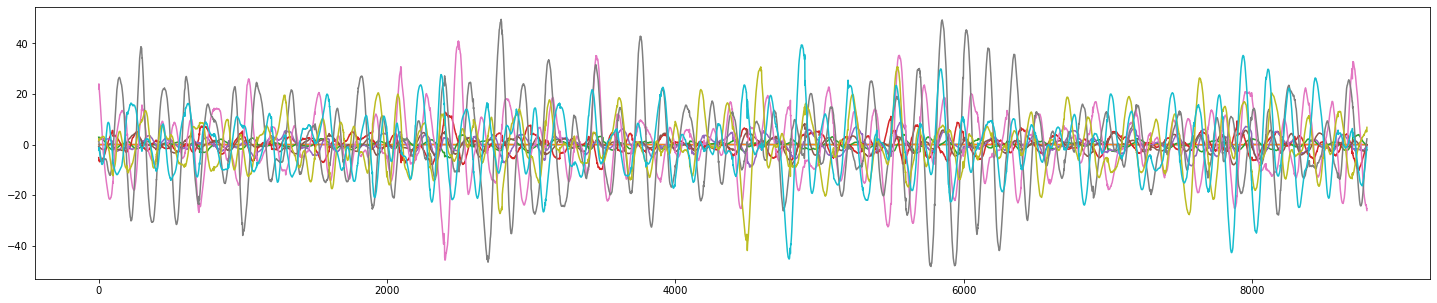

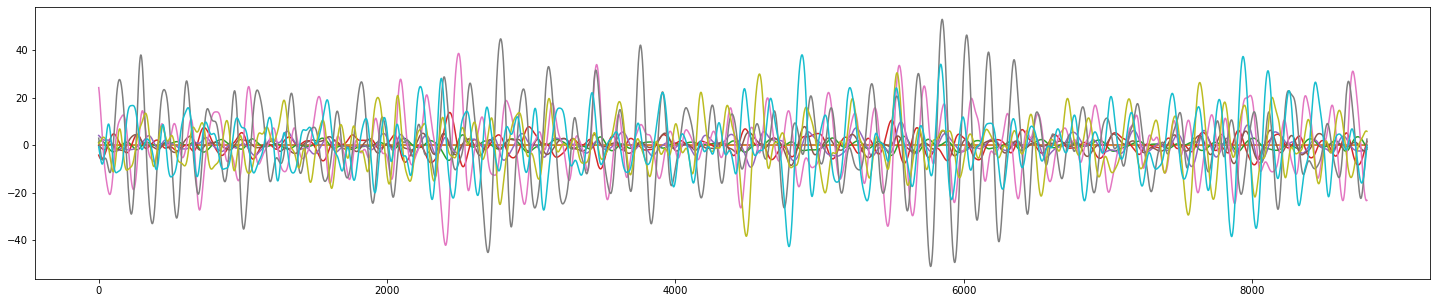

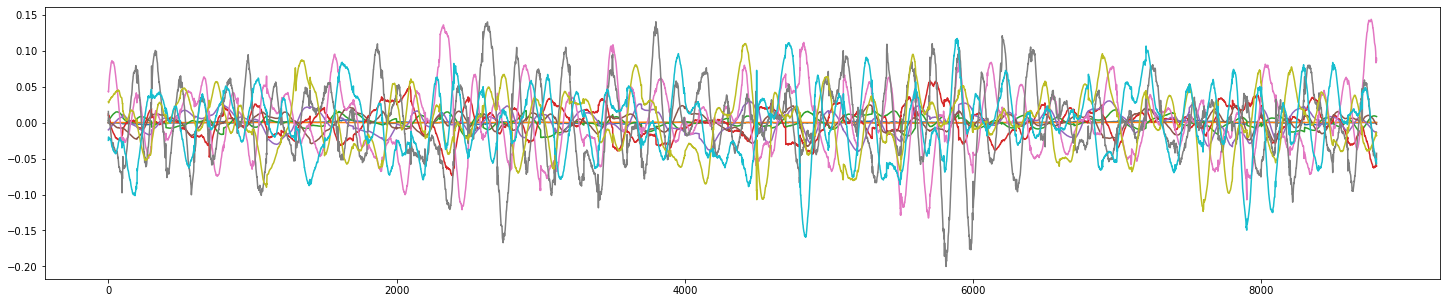

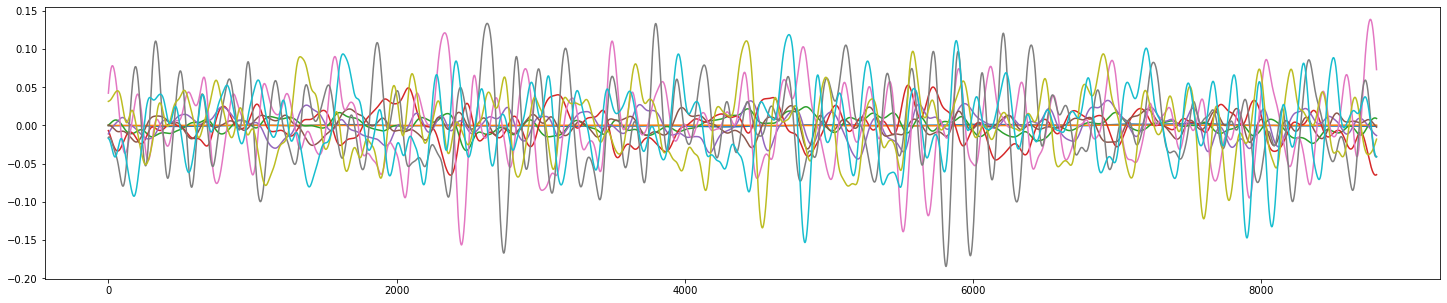

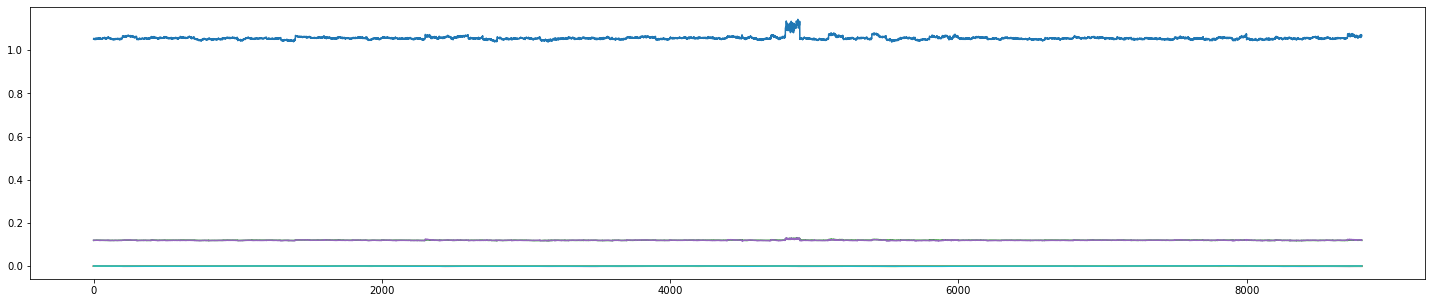

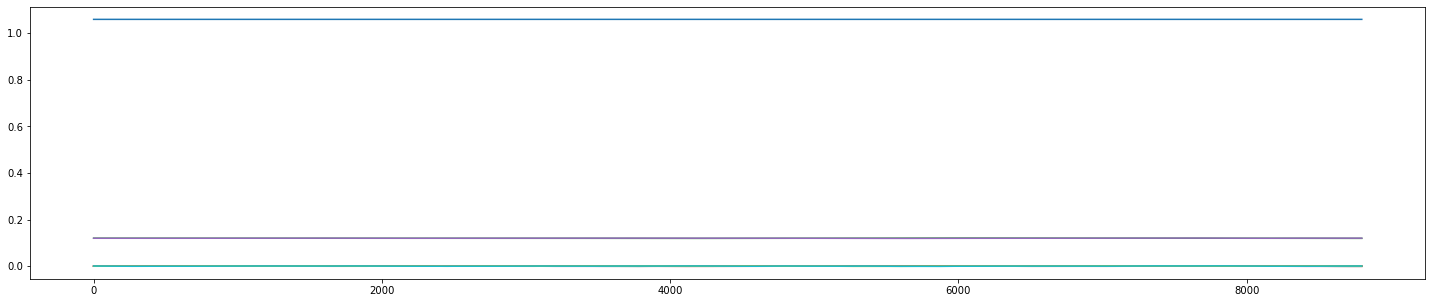

In [21]:
 #####test################
model=SeATransConv_PINN()
model.load_weights('./SeATransConv_PINN.h5')

start = int(len(scaled_train_Irr_data)*0.85)
test_input = scaled_train_Irr_data[start : start+90]
test_output_A = scaled_train_A_data[start: start+90]
test_output_V = scaled_train_V_data[start: start+90]
test_output_U = scaled_train_U_data[start: start+90]
test_F_data = scaled_train_F_data[start: ]

batch_size=8
num  = int(len(test_input)/batch_size)
predicted_results_A = []
predicted_results_V = []
predicted_results_U = []
real_results_A = []
real_results_V = []
real_results_U = []
for i in range(num):
    tem_Irr_data = test_input[i*batch_size:(i+1)*batch_size]
    tem_F_data = test_F_data [i*batch_size:(i+1)*batch_size]
    predicted_Y = model([tem_Irr_data,tem_F_data])
    for j in range(batch_size):
        predicted_results_A.extend(predicted_Y[0][j])
        real_results_A.extend(test_output_A[i*batch_size:(i+1)*batch_size][j])
        predicted_results_V.extend(predicted_Y[1][j])
        real_results_V.extend(test_output_V[i*batch_size:(i+1)*batch_size][j])
        predicted_results_U.extend(predicted_Y[2][j])
        real_results_U.extend(test_output_U[i*batch_size:(i+1)*batch_size][j])
predicted_results_A = np.array(predicted_results_A)
real_results_A = np.array(real_results_A)
predicted_results_V = np.array(predicted_results_V)
real_results_V = np.array(real_results_V)
predicted_results_U = np.array(predicted_results_U)
real_results_U = np.array(real_results_U)
print(predicted_results_A.shape)
print(real_results_A.shape)

#predicted_shape = predicted_results_A.shape
#Predicted_A = scaler_A.inverse_transform(predicted_results_A.reshape(-1,1)).reshape(predicted_shape)
#Real_A= scaler_A.inverse_transform(real_results_A.reshape(-1,1)).reshape(predicted_shape)
Predicted_A = (mean_A + predicted_results_A*std_A)/np.array(A_w) 
Real_A = (mean_A + real_results_A*std_A)/np.array(A_w) 
Predicted_V = (mean_V + predicted_results_V*std_V)/np.array(V_w) 
Real_V = (mean_V + real_results_V*std_V)/np.array(V_w) 
Predicted_U = (mean_U + predicted_results_U*std_U)/np.array(D_w) 
Real_U = (mean_U + real_results_U*std_U)/np.array(D_w) 
plt.figure(figsize=(25,5))
plt.plot(Predicted_A)
plt.show()
plt.figure(figsize=(25,5))
plt.plot(Real_A)
plt.show()
plt.figure(figsize=(25,5))
plt.plot(Predicted_V)
plt.show()
plt.figure(figsize=(25,5))
plt.plot(Real_V)
plt.show()
plt.figure(figsize=(25,5))
plt.plot(Predicted_U)
plt.show()
plt.figure(figsize=(25,5))
plt.plot(Real_U)
plt.show()